# 03 BMRA

Run BMRA based on global responses derived from the pathway activity predictions.

In [1]:
import pandas as pd
import numpy as np
import os
import bmra

In [2]:
data_dir_1 = "01_outputs_2020"
data_dir_2 = "02_outputs_2020"
info_dir = "/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg"
out_dir = "03_outputs_2020"


os.makedirs(out_dir, exist_ok = True)

## Load data

### Global responses

Assembled from global responses calculated from predicted pathway activities, and DPD global responses.

In [3]:
def assemble_R_global(pathway_rglobal_file, dpd_rglobal_file):
    """
    Assemble full R_global matrix
    """
    R_global_modules_df = pd.read_csv(pathway_rglobal_file, index_col = 0)

    perts = R_global_modules_df.columns.tolist()

    R_global_DPD_df = pd.read_csv(dpd_rglobal_file, index_col=0).T

    # filter by perts list
    R_global_DPD_df = R_global_DPD_df[R_global_DPD_df.index.isin(perts)]

    # sort by perts list
    R_global_DPD_df["sort_col"] = R_global_DPD_df.index.map({val: i for i, val in enumerate(perts)})
    R_global_DPD_df = R_global_DPD_df.sort_values("sort_col")
    R_global_DPD_df = R_global_DPD_df.drop("sort_col", axis = 1)

    # transpose
    R_global_DPD_df = R_global_DPD_df.T

    R_global_df = pd.concat([R_global_modules_df, R_global_DPD_df])

    return R_global_df

In [4]:
R_global_df = assemble_R_global(
    pathway_rglobal_file = os.path.join(data_dir_2, "R_global_annotated.csv"),
    dpd_rglobal_file = os.path.join(data_dir_1, "R_global_DPDonly_annotated.csv"),
)

modules = R_global_df.index.tolist()
exp_ids = R_global_df.columns.tolist()

R_global = R_global_df.values
n_modules = R_global.shape[0]

print(R_global.shape)
display(R_global_df)

(12, 77)


,ASG002_U251MG_24H:A10,ASG002_U251MG_24H:A11,ASG002_U251MG_24H:A12,ASG002_U251MG_24H:B10,ASG002_U251MG_24H:B11,ASG002_U251MG_24H:B12,ASG002_U251MG_24H:B13,ASG002_U251MG_24H:B14,ASG002_U251MG_24H:B15,ASG002_U251MG_24H:C13,...,ASG002_U251MG_24H:M24,ASG002_U251MG_24H:N22,ASG002_U251MG_24H:N23,ASG002_U251MG_24H:N24,ASG002_U251MG_24H:O10,ASG002_U251MG_24H:O11,ASG002_U251MG_24H:O12,ASG002_U251MG_24H:P16,ASG002_U251MG_24H:P17,ASG002_U251MG_24H:P18
CDK2,0.101357,0.091644,-0.011664,0.087686,0.064857,0.091521,0.064048,0.092035,0.045154,0.030990,...,-0.006453,0.029285,0.018378,0.036078,0.073183,-0.001857,0.010707,0.053579,0.096947,-0.138181
CDK4_6,-0.034357,0.036793,0.026019,0.012811,0.022456,-0.015895,0.000758,0.015820,0.024788,0.055157,...,0.070051,-0.021989,0.054412,0.041647,0.014063,0.006247,-0.014568,-1.631479,-1.743889,-1.076619
PI3K,-1.669712,-1.764209,-1.545644,-0.174345,-0.196639,-0.207423,-0.259894,0.007741,-0.174983,-0.145027,...,0.369050,0.104077,-0.026382,0.015187,0.325997,-0.075631,-0.870298,-0.662333,-0.788470,-0.511995
ERK,-1.469459,-1.028573,-0.546271,-0.146435,-0.109047,-0.025887,-0.391860,-0.354929,-0.278114,0.161364,...,0.068806,-0.385717,-0.206668,0.015066,-0.808200,-0.089949,-0.241376,-0.971398,-1.975775,-0.884842
Estrogen,0.033600,0.083975,-0.374553,-0.134055,0.053906,-0.007647,-0.072635,0.031748,0.048555,-0.009413,...,0.019624,-0.258324,-0.042496,-0.044841,-1.658097,-1.390205,-1.384676,-0.318060,0.046600,-0.520283
EGFR,0.250455,0.395755,0.391870,-1.615584,-1.015745,0.369658,-1.616013,0.410079,-1.460245,0.244499,...,-1.670109,-1.959398,-1.464856,-1.305295,0.336689,0.353402,0.509683,-1.899952,0.306972,-1.270785
Hypoxia,-0.447556,0.141019,0.035113,0.083284,-0.046762,-0.125243,-0.202349,-0.028788,0.039342,0.068563,...,0.123890,-0.360140,0.144481,0.144646,0.104394,0.108165,-0.870917,0.027112,0.089020,-0.090083
PDGFR,-0.250544,-0.249063,-0.472509,-0.132442,-0.010820,0.044822,0.348820,0.294072,-0.282405,-0.391744,...,-0.225484,-0.052685,-0.380897,-0.390259,-0.823086,-0.056546,-0.630311,-1.859303,-1.167074,0.792055
Aurora,0.459537,-0.935912,0.284422,-1.537009,-1.989747,-1.584379,-1.529648,-1.996551,-1.651560,0.241831,...,0.024702,-0.653678,-1.512730,-1.549700,0.595733,-0.198569,0.305802,-1.064181,-0.975460,-1.058906
p53,-0.227789,0.249000,0.094384,-1.596627,-1.575652,-1.504748,-0.776855,-0.280511,0.031146,-1.635389,...,0.395466,0.140098,-0.465580,-1.084122,-0.519081,-0.979045,0.425623,0.152296,0.041817,0.005067


In [5]:
print(R_global_df.values.min())
print(R_global_df.values.max())

-19.044110414335425
21.871067677004643


### Perturbation matrix

In [6]:
inhib_conc_df = pd.read_csv(os.path.join(data_dir_1, "inhib_conc_annotated.csv"), index_col = 0)
#LFC_PLCg = pd.read_csv(os.path.join(info_dir,"PLCg_Data_log_2020.csv"),index_col=0)
#inhib_conc = inhib_conc_df.drop(columns=LFC_PLCg.index).values
inhib_conc = inhib_conc_df.values

n_DPDs = R_global.shape[0] - inhib_conc.shape[0]

pert_modules = np.where(inhib_conc != 0, 1, 0)
pert_DPD = np.zeros((n_DPDs, len(exp_ids)))

pert = np.vstack([pert_modules, pert_DPD])

print(pert.shape)
print(pert)

(12, 77)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
  0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Networks

In [7]:
# empty prior
#G_prior = np.zeros((n_modules, n_modules))
G_prior_df = pd.read_excel('/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg/00_outputs_2020_U251MG/ALL_DATA_2020_Jing_u251mg.xlsx', sheet_name = "prior_network", index_col = 0)

G_prior = G_prior_df.values
G_prior_df

,CDK2,CDK4_6,p53,EGFR,Aurora,Estrogen,PDGFR,Hypoxia,ERK,PI3K,DPD_GBM_onc,DPD_GBM_survival
CDK2,0,0,0,0,0,0,0,0,0,0,0,0
CDK4_6,0,0,0,0,0,0,0,0,0,0,0,0
p53,0,0,0,0,0,0,0,0,0,0,0,0
EGFR,0,0,0,0,0,0,0,0,0,0,0,0
Aurora,0,0,0,0,0,0,0,0,0,0,0,0
Estrogen,0,0,0,0,0,0,0,0,0,0,0,0
PDGFR,0,0,0,0,0,0,0,0,0,0,0,0
Hypoxia,0,0,0,0,0,0,0,0,0,0,0,0
ERK,0,0,0,0,0,0,0,0,0,0,0,0
PI3K,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
#G_prior_r_df = pd.read_excel(os.path.join(info_dir, "ALL_DATA_2020.xlsx"), sheet_name = "prior_r", index_col = 0)

#G_prior_r = G_prior_r_df.values
#G_prior_r_df

In [9]:
G_not = np.eye(n_modules)
G_not[:, n_modules - n_DPDs :] = 1

G_not

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

## Run BMRA

In [10]:
n_gibbs = 200_000
n_window = 5_000

mode = "all"
n_iterations = 1

In [11]:
G_prior

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
A_mean, A_sd, r_mean, r_sd = bmra.run_bmra(R_global,
            pert,
            G_prior,
            G_not,
            #r_prior = G_prior_r,
            n_gibbs = n_gibbs,
            n_window = n_window,
            mode = mode,
            n_iterations = n_iterations,
        )

A_mean_df = pd.DataFrame(A_mean, index = modules, columns = modules)
A_sd_df = pd.DataFrame(A_sd, index = modules, columns = modules)
r_mean_df = pd.DataFrame(r_mean, index = modules, columns = modules)
r_sd_df = pd.DataFrame(r_sd, index = modules, columns = modules)

display(A_mean_df)
display(A_sd_df)
display(r_mean_df)
display(r_sd_df)

A_mean_df.to_csv(os.path.join(out_dir, "A_mean.csv"))
A_sd_df.to_csv(os.path.join(out_dir, "A_sd.csv"))
r_mean_df.to_csv(os.path.join(out_dir, "r_mean.csv"))
r_sd_df.to_csv(os.path.join(out_dir, "r_sd.csv"))

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.00000,0.000000,0.000000,0.000000,0.000000,0.189042,0.000000,0.000000,0.099521,0.000000,0.0,0.0
CDK4_6,0.00000,0.000000,0.000000,0.944796,0.000000,0.001304,0.000000,0.000000,0.002180,0.000000,0.0,0.0
PI3K,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
Hypoxia,0.00011,0.052719,0.029952,0.369569,0.000302,0.059695,0.000000,0.837169,0.829309,0.002207,0.0,0.0
PDGFR,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
Aurora,0.00000,0.000000,0.000000,0.000370,0.000000,1.000000,0.286341,0.285971,0.000000,1.000000,0.0,0.0
p53,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,3.915424e-01,0.000000e+00,0.000000,2.993600e-01,0.000000e+00,0.0,0.0
CDK4_6,0.000000,0.000000e+00,0.000000e+00,2.283771e-01,0.000000,3.608588e-02,0.000000e+00,0.000000,4.663965e-02,0.000000e+00,0.0,0.0
PI3K,0.000000,0.000000e+00,0.000000e+00,1.221245e-15,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
ERK,0.000000,1.998401e-15,1.998401e-15,0.000000e+00,0.000000,0.000000e+00,1.998401e-15,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
Estrogen,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.554312e-15,1.554312e-15,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
EGFR,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2.664535e-15,0.000000e+00,0.0,0.0
Hypoxia,0.010481,2.234716e-01,1.704553e-01,4.826880e-01,0.017371,2.369200e-01,0.000000e+00,0.369211,3.762386e-01,4.692732e-02,0.0,0.0
PDGFR,0.000000,2.886580e-15,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2.886580e-15,0.000000e+00,0.0,0.0
Aurora,0.000000,0.000000e+00,0.000000e+00,1.922912e-02,0.000000,2.442491e-15,4.520507e-01,0.451876,0.000000e+00,2.442491e-15,0.0,0.0
p53,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,3.330669e-15,0.000000e+00,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004312,0.000000,0.000000,-0.001729,0.000000,0.0,0.0
CDK4_6,0.000000,0.000000,0.000000,0.058395,0.000000,0.000005,0.000000,0.000000,-0.000013,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.000000,0.204961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.000000,0.563556,0.438324,0.000000,0.000000,0.000000,0.349242,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.126392,0.292623,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.498660,0.000000,0.0,0.0
Hypoxia,0.000006,-0.012821,0.003648,0.050710,-0.000006,-0.004539,0.000000,0.179213,-0.069450,0.000090,0.0,0.0
PDGFR,0.000000,0.430331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143485,0.000000,0.0,0.0
Aurora,0.000000,0.000000,0.000000,0.000087,0.000000,0.513602,-0.086847,0.097929,0.000000,0.559628,0.0,0.0
p53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225231,0.000000,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009234,0.000000,0.000000,0.005322,0.000000,0.0,0.0
CDK4_6,0.000000,0.000000,0.000000,0.023756,0.000000,0.000278,0.000000,0.000000,0.000410,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.000000,0.001319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.000000,0.047879,0.031585,0.000000,0.000000,0.000000,0.026506,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.005260,0.008858,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001855,0.000000,0.0,0.0
Hypoxia,0.000561,0.057730,0.022500,0.070185,0.000392,0.018877,0.000000,0.091923,0.038832,0.002601,0.0,0.0
PDGFR,0.000000,0.034850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011445,0.000000,0.0,0.0
Aurora,0.000000,0.000000,0.000000,0.004533,0.000000,0.029158,0.141057,0.159069,0.000000,0.039246,0.0,0.0
p53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001027,0.000000,0.0,0.0


In [13]:
np.fill_diagonal(r_mean_df.values,-1)
rm_minus_inv = pd.DataFrame(np.linalg.pinv(r_mean_df),index=r_mean_df.index,columns=r_mean_df.columns)*(-1)
rm_minus_inv.to_csv(os.path.join(out_dir, 'r_minv.csv'))
display(rm_minus_inv)

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.000000e+00,-0.000227,0.000009,0.000017,-3.562674e-09,-0.007636,0.000568,-0.000532,-0.006467,-0.003619,2.193110e-18,1.596247e-18
CDK4_6,1.407458e-07,1.039821,0.029923,0.068067,-1.502179e-07,-0.001048,0.023932,0.004109,-0.001839,-0.001027,-3.249925e-16,-3.591474e-16
PI3K,4.939729e-07,0.139769,1.105026,0.238908,-5.272170e-07,-0.003667,0.083992,0.014426,-0.006398,-0.003573,-1.342572e-16,-4.794470e-16
ERK,2.410078e-06,0.681929,0.512416,1.165625,-2.572274e-06,-0.017890,0.409796,0.070384,-0.031217,-0.017433,-5.149490e-16,-2.597879e-16
Estrogen,1.717238e-06,0.032728,0.009225,0.018616,9.999982e-01,0.167259,0.291989,0.060373,0.082149,0.045999,-1.771785e-16,-9.930710e-17
EGFR,-4.291384e-07,0.029120,-0.001221,-0.002177,4.580191e-07,1.427361,-0.072968,0.068345,0.831441,0.465291,1.098812e-16,-4.835199e-16
Hypoxia,6.053795e-06,0.099265,0.032052,0.064558,-6.461211e-06,-0.044932,1.029352,0.176797,-0.078387,-0.043775,-2.862305e-16,-5.703393e-16
PDGFR,-6.291350e-08,0.455846,0.012525,0.028665,6.714753e-08,0.122519,-0.010697,1.021434,0.238448,0.133441,9.883846e-17,2.536765e-16
Aurora,-8.605822e-07,0.058396,-0.002448,-0.004367,9.184988e-07,0.857019,-0.146328,0.137058,1.667348,0.933081,-2.586948e-17,3.674458e-16
p53,-1.938302e-07,0.013153,-0.000551,-0.000984,2.068749e-07,0.193028,-0.032958,0.030870,0.375539,1.210159,1.791412e-16,-5.130607e-16


In [14]:
con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in r_mean_df.index:
    for con_from in r_mean_df.columns:
        if ((r_mean_df.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,r_mean_df.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net.txt'),sep='\t',index=False)
display(con_mat)

,From,To,Strength
0,EGFR,CDK2,-0.004312
1,Aurora,CDK2,-0.001729
2,ERK,CDK4_6,0.058395
3,EGFR,CDK4_6,0.000005
4,Aurora,CDK4_6,-0.000013
5,ERK,PI3K,0.204961
6,CDK4_6,ERK,0.563556
7,PI3K,ERK,0.438324
8,Hypoxia,ERK,0.349242
9,EGFR,Estrogen,0.126392


In [15]:
# now the same but with filtered matrices
# threshold value
Athr = 0.5

rm_filt = r_mean_df[np.abs(A_mean_df) > Athr].fillna(0).copy()
np.fill_diagonal(rm_filt.values,-1)
rm_filt.to_csv(os.path.join(out_dir, 'r_mean_filt.csv'))
display(rm_filt)

rm_filt_minus_inv = pd.DataFrame(np.linalg.pinv(rm_filt),index=rm_filt.index,columns=rm_filt.columns)*(-1)
rm_filt_minus_inv.to_csv(os.path.join(out_dir, 'r_minv_filt.csv'))
display(rm_minus_inv)

con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in rm_filt.index:
    for con_from in rm_filt.columns:
        if ((rm_filt.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,rm_filt.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net_filt.txt'),sep='\t',index=False)
#display(con_mat)


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.058395,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.204961,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.563556,0.438324,-1.000000,0.0,0.000000,0.349242,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.126392,0.292623,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,0.498660,0.000000,0.0,0.0
Hypoxia,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-1.000000,0.179213,-0.069450,0.000000,0.0,0.0
PDGFR,0.0,0.430331,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.143485,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.513602,0.000000,0.000000,-1.000000,0.559628,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.225231,-1.000000,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.000000e+00,-0.000227,0.000009,0.000017,-3.562674e-09,-0.007636,0.000568,-0.000532,-0.006467,-0.003619,2.193110e-18,1.596247e-18
CDK4_6,1.407458e-07,1.039821,0.029923,0.068067,-1.502179e-07,-0.001048,0.023932,0.004109,-0.001839,-0.001027,-3.249925e-16,-3.591474e-16
PI3K,4.939729e-07,0.139769,1.105026,0.238908,-5.272170e-07,-0.003667,0.083992,0.014426,-0.006398,-0.003573,-1.342572e-16,-4.794470e-16
ERK,2.410078e-06,0.681929,0.512416,1.165625,-2.572274e-06,-0.017890,0.409796,0.070384,-0.031217,-0.017433,-5.149490e-16,-2.597879e-16
Estrogen,1.717238e-06,0.032728,0.009225,0.018616,9.999982e-01,0.167259,0.291989,0.060373,0.082149,0.045999,-1.771785e-16,-9.930710e-17
EGFR,-4.291384e-07,0.029120,-0.001221,-0.002177,4.580191e-07,1.427361,-0.072968,0.068345,0.831441,0.465291,1.098812e-16,-4.835199e-16
Hypoxia,6.053795e-06,0.099265,0.032052,0.064558,-6.461211e-06,-0.044932,1.029352,0.176797,-0.078387,-0.043775,-2.862305e-16,-5.703393e-16
PDGFR,-6.291350e-08,0.455846,0.012525,0.028665,6.714753e-08,0.122519,-0.010697,1.021434,0.238448,0.133441,9.883846e-17,2.536765e-16
Aurora,-8.605822e-07,0.058396,-0.002448,-0.004367,9.184988e-07,0.857019,-0.146328,0.137058,1.667348,0.933081,-2.586948e-17,3.674458e-16
p53,-1.938302e-07,0.013153,-0.000551,-0.000984,2.068749e-07,0.193028,-0.032958,0.030870,0.375539,1.210159,1.791412e-16,-5.130607e-16


In [16]:
# number of zero elements in the matrix
display(len(rm_filt.index)*len(rm_filt.columns) - rm_filt.astype(bool).sum().sum())

111

In [17]:
# number of non-zero elements in the matrix
display(rm_filt.astype(bool).sum().sum() - len(modules))

21

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
rm_minus_inv=pd.read_csv(os.path.join(out_dir, 'r_minv.csv'),index_col=0)
display(rm_minus_inv)

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.000000e+00,-0.000227,0.000009,0.000017,-3.562674e-09,-0.007636,0.000568,-0.000532,-0.006467,-0.003619,2.193110e-18,1.596247e-18
CDK4_6,1.407458e-07,1.039821,0.029923,0.068067,-1.502179e-07,-0.001048,0.023932,0.004109,-0.001839,-0.001027,-3.249925e-16,-3.591474e-16
PI3K,4.939729e-07,0.139769,1.105026,0.238908,-5.272170e-07,-0.003667,0.083992,0.014426,-0.006398,-0.003573,-1.342572e-16,-4.794470e-16
ERK,2.410078e-06,0.681929,0.512416,1.165625,-2.572274e-06,-0.017890,0.409796,0.070384,-0.031217,-0.017433,-5.149490e-16,-2.597879e-16
Estrogen,1.717238e-06,0.032728,0.009225,0.018616,9.999982e-01,0.167259,0.291989,0.060373,0.082149,0.045999,-1.771785e-16,-9.930710e-17
EGFR,-4.291384e-07,0.029120,-0.001221,-0.002177,4.580191e-07,1.427361,-0.072968,0.068345,0.831441,0.465291,1.098812e-16,-4.835199e-16
Hypoxia,6.053795e-06,0.099265,0.032052,0.064558,-6.461211e-06,-0.044932,1.029352,0.176797,-0.078387,-0.043775,-2.862305e-16,-5.703393e-16
PDGFR,-6.291350e-08,0.455846,0.012525,0.028665,6.714753e-08,0.122519,-0.010697,1.021434,0.238448,0.133441,9.883846e-17,2.536765e-16
Aurora,-8.605822e-07,0.058396,-0.002448,-0.004367,9.184988e-07,0.857019,-0.146328,0.137058,1.667348,0.933081,-2.586948e-17,3.674458e-16
p53,-1.938302e-07,0.013153,-0.000551,-0.000984,2.068749e-07,0.193028,-0.032958,0.030870,0.375539,1.210159,1.791412e-16,-5.130607e-16


In [20]:
rm_minus_inv.columns

Index(['CDK2', 'CDK4_6', 'PI3K', 'ERK', 'Estrogen', 'EGFR', 'Hypoxia', 'PDGFR',
       'Aurora', 'p53', 'GBM_onc', 'GBM_survival'],
      dtype='object')

In [22]:
df_subset=rm_minus_inv[[ 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'Estrogen', 'EGFR', 'Hypoxia',
       'PDGFR', 'Aurora', 'p53']]
df_subset = df_subset.loc[['GBM_onc', 'GBM_survival']]

In [23]:
t_df_subset=df_subset.T

In [24]:
df_subset.reset_index(inplace=True)

In [25]:
df_subset

,index,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53
0,GBM_onc,-0.000007,-0.331921,-0.263405,-0.435370,0.000007,-0.370066,-1.165077,-0.235873,-0.276491,-0.618387
1,GBM_survival,-0.000015,-3.470627,-2.730353,-6.207731,0.000016,2.360300,-2.565140,-0.011883,4.572941,2.558913


Text(0.5, 1.0, 'Predicted global signaling pathway responses of U251MG cell line under conditions ')

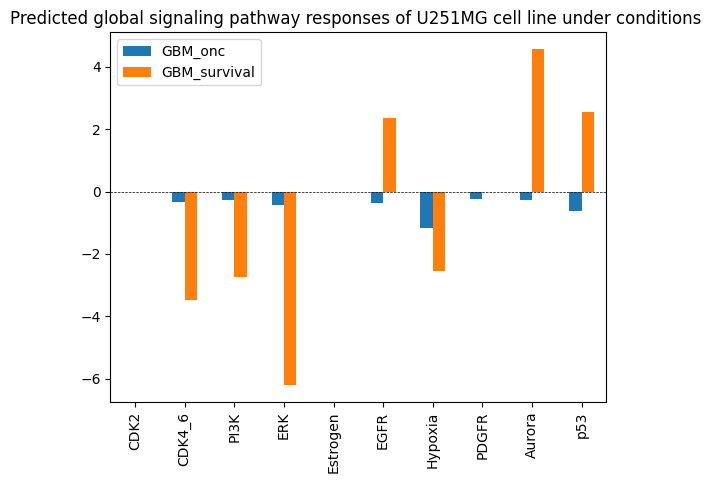

In [26]:
t_df_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted global signaling pathway responses of U251MG cell line under conditions ")

In [27]:
rm_filt

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.058395,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.204961,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.563556,0.438324,-1.000000,0.0,0.000000,0.349242,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.126392,0.292623,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,0.498660,0.000000,0.0,0.0
Hypoxia,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-1.000000,0.179213,-0.069450,0.000000,0.0,0.0
PDGFR,0.0,0.430331,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.143485,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.513602,0.000000,0.000000,-1.000000,0.559628,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.225231,-1.000000,0.0,0.0


In [29]:
display(rm_filt)
rm_subset=rm_filt[['CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora','Estrogen', 'EGFR','Hypoxia', 'p53']]

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,Hypoxia,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.058395,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.204961,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.563556,0.438324,-1.000000,0.0,0.000000,0.349242,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.126392,0.292623,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,0.498660,0.000000,0.0,0.0
Hypoxia,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-1.000000,0.179213,-0.069450,0.000000,0.0,0.0
PDGFR,0.0,0.430331,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.143485,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.513602,0.000000,0.000000,-1.000000,0.559628,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.225231,-1.000000,0.0,0.0


In [30]:
rm_subset

,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,Hypoxia,p53
CDK2,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
CDK4_6,0.0,-1.000000,0.000000,0.058395,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
PI3K,0.0,0.000000,-1.000000,0.204961,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ERK,0.0,0.563556,0.438324,-1.000000,0.000000,0.000000,0.0,0.000000,0.349242,0.000000
Estrogen,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.126392,0.292623,0.000000
EGFR,0.0,0.000000,0.000000,0.000000,0.000000,0.498660,0.0,-1.000000,0.000000,0.000000
Hypoxia,0.0,0.000000,0.000000,0.000000,0.179213,-0.069450,0.0,0.000000,-1.000000,0.000000
PDGFR,0.0,0.430331,0.000000,0.000000,-1.000000,0.143485,0.0,0.000000,0.000000,0.000000
Aurora,0.0,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.513602,0.000000,0.559628
p53,0.0,0.000000,0.000000,0.000000,0.000000,0.225231,0.0,0.000000,0.000000,-1.000000


In [31]:
rm_subset=rm_subset.loc[['GBM_onc','GBM_survival']]
rm_subset=rm_subset.T
display(rm_subset)

,GBM_onc,GBM_survival
CDK2,0.000000,0.000000
CDK4_6,0.000000,0.000000
PI3K,0.000000,0.000000
ERK,-0.302894,-5.315765
PDGFR,0.000000,0.000000
Aurora,0.000000,2.643117
Estrogen,0.000000,0.000000
EGFR,-0.233347,0.000000
Hypoxia,-1.037042,0.000000
p53,-0.463550,0.000000


Text(0.5, 1.0, 'Predicted local signaling pathway responses of U251MG cell line under conditions ')

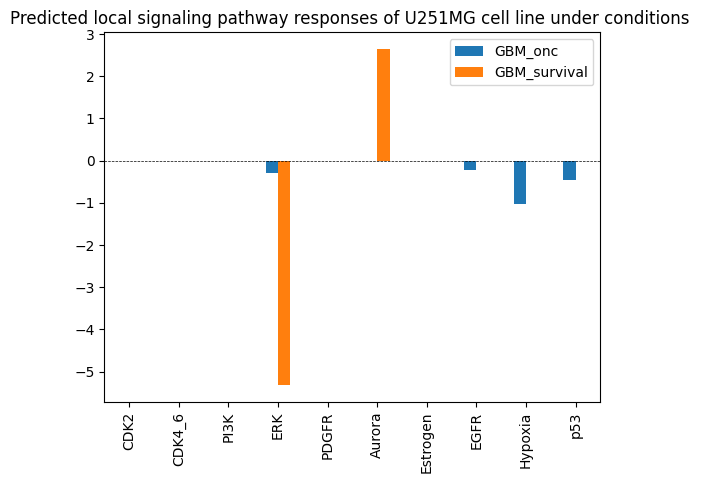

In [32]:
rm_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted local signaling pathway responses of U251MG cell line under conditions ")